# Convolutional Neural Network for Text Classification

## Preliminaries

### Imports

In [1]:
import os
import pickle 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics


import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
print(tf.__version__)

%matplotlib inline

import sys
sys.path.append("../..")

from E4525_ML import text
from E4525_ML import plots

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [2]:
#
from tensorflow.keras.backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)

sess = tf.Session(config=config)

set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
seed=456
np.random.seed(seed)

### Data

In [4]:
reviews_filename="../../raw/amazon-reviews/Reviews.csv"

In [5]:
data=pd.read_csv(reviews_filename)

In [6]:
data_dir=r"../../data/amazon-reviews"
model_dir=r"../../data/models/tf/AmazonReviews_Binary_Embedding"
dense_model_dir=r"../../data/models/tf/AmazonReviews_Binary_CNN"

### Split into Train, Validation and Test Sets

In [7]:
documents_all=data["Text"].as_matrix()
labels_all=data["Score"].as_matrix()
print(documents_all.shape)

(568454,)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [8]:
docs,docs_test,labels,labels_test=train_test_split(documents_all,labels_all,test_size=0.1)
print(docs.shape,docs_test.shape)

(511608,) (56846,)


In [9]:
docs_train,docs_val,labels_train,labels_val=train_test_split(docs,labels,test_size=0.05)
print(docs_train.shape,docs_val.shape)

(486027,) (25581,)


## Text Embedding Pipeline

In [10]:
countVectorizer=TfidfVectorizer(input="content",decode_error="ignore",
                                       max_features=50000,
                                       tokenizer=text.stem_tokenizer,
                                       stop_words=text.stop_words())
dencoder=text.DocumentEncoder(countVectorizer)


In [11]:
pickle_filename=data_dir+"/amazon_reviews.p"
if False:
    texts_train=dencoder.fit_transform(docs_train)
    texts_val=dencoder.transform(docs_val)
    texts_test=dencoder.transform(docs_test)
    
    file=open(pickle_filename,"wb")
    pickle.dump((countVectorizer,texts_train,labels_train,texts_val,labels_val,texts_test,labels_test),file)
    file.close()
else:
    file=open(pickle_filename,"rb")
    countVectorizer,texts_train,labels_train,texts_val,labels_val,texts_test,labels_test=pickle.load(file)
    file.close()
print(texts_train.shape,texts_val.shape,texts_test.shape)

(486027,) (25581,) (56846,)


In [12]:
ltexts=[len(text) for text in texts_train]

(array([189251., 161099.,  66112.,  30420.,  15775.,   8397.,   5174.,
          3155.,   1873.,   1325.]),
 array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.]),
 <a list of 10 Patch objects>)

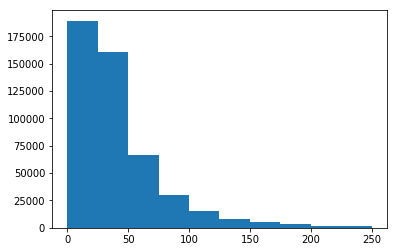

In [13]:
plt.hist(ltexts,range=[0,250])

In [14]:
def pad_texts(texts,W):
    fragments=[]
    fragment_labels=[]
    for idx,text in enumerate(texts):
            fragment=text[0:W]
            fragment=np.pad(fragment,(W-len(fragment),0),mode="constant",constant_values=-2)
            fragments.append(fragment)
    return np.array(fragments)

In [15]:
W=125

In [16]:
X_train=pad_texts(texts_train,W)
Y_train=labels_train>3
print(X_train.shape,Y_train.shape)

(486027, 125) (486027,)


In [17]:
X_val=pad_texts(texts_val,W)
Y_val=labels_val>3
print(X_val.shape,Y_val.shape)

(25581, 125) (25581,)


In [18]:
X_test=pad_texts(texts_test,W)
Y_test=labels_test>3
print(X_test.shape,Y_test.shape)

(56846, 125) (56846,)


In [19]:
X_train[0]

array([   -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,
          -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,
          -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,
          -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,
          -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,
          -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,
          -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,    -2,
          -2,    -2,    -2,    -2,    -2,    -2, 44803, 13593, 47940,
       36788, 34153,  9351, 24531, 17572, 13193,  9643, 14300, 28088,
       31308, 11587, 28797,  8446, 40548, 34153, 24183, 49253,  6316,
       42502, 21165, 46663, 11970, 18782, 11587, 18468, 43340,  6436,
       31441,  6530, 45450, 35687, 13593, 47940, 23530, 35695, 32607,
       40813, 43570, 48687, 48538, 35695, 32607, 40679, 10450,  8228,
       38300, 35258, 14233, 37844,  6436, 17760, 14310, 46274])

In [20]:
X_train.max(),X_train.min()

(49999, -2)

## Text Embedding Model

In [21]:
num_classes = 2
V=len(countVectorizer.vocabulary_)+2 # one for unknown words, one for padding
print(num_classes,V)
E=128
F=128
hidden1=128

2 50002


## Convolutional Neural Network

### Build Dense Neural Network

In [22]:
def text_conv_net(W,V,E,F,hidden1):
    input1 = keras.layers.Input(shape=(W,))
    embedding= keras.layers.Embedding(V,E,input_length=W)(input1)
    conv1 = keras.layers.Convolution1D(F,2, padding="same")(embedding)
    features1=keras.layers.MaxPooling1D(pool_size=W)(conv1)
    conv2 = keras.layers.Convolution1D(F,3, padding="same")(embedding)
    features2=keras.layers.MaxPooling1D(pool_size=W)(conv2)
    conv3 = keras.layers.Convolution1D(F,4, padding="same")(embedding)
    features3=keras.layers.MaxPooling1D(pool_size=W)(conv3)
    concat= keras.layers.concatenate([features1,features2,features3])
    flat=keras.layers.Flatten()(concat)
    drop1=keras.layers.Dropout(0.5)(flat)
    dense1=keras.layers.Dense(hidden1, activation=keras.activations.relu)(drop1)
    drop2=keras.layers.Dropout(0.5)(dense1)
    out = keras.layers.Dense(1,activation="sigmoid")(drop2)
    model = keras.models.Model(inputs=[input1], outputs=out)
    return model

In [23]:
model=text_conv_net(W,V,E,F,hidden1)

In [24]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 125)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 125, 128)     6400256     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 125, 128)     32896       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 125, 128)     49280       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

In [26]:
X_train.shape

(486027, 125)

In [28]:
model.fit(X_train,Y_train,epochs=10,validation_data=(X_val,Y_val),batch_size=100)

Train on 486027 samples, validate on 25581 samples
Epoch 1/10
486027/486027 [==============================] - 93s 192us/step - loss: 0.2634 - acc: 0.8920 - val_loss: 0.2093 - val_acc: 0.9154
Epoch 2/10
486027/486027 [==============================] - 93s 191us/step - loss: 0.1841 - acc: 0.9283 - val_loss: 0.1936 - val_acc: 0.9246
Epoch 3/10
486027/486027 [==============================] - 93s 192us/step - loss: 0.1437 - acc: 0.9450 - val_loss: 0.1884 - val_acc: 0.9282
Epoch 4/10
486027/486027 [==============================] - 93s 191us/step - loss: 0.1160 - acc: 0.9562 - val_loss: 0.1995 - val_acc: 0.9277
Epoch 5/10
486027/486027 [==============================] - 93s 191us/step - loss: 0.0956 - acc: 0.9638 - val_loss: 0.2062 - val_acc: 0.9287
Epoch 6/10
486027/486027 [==============================] - 93s 191us/step - loss: 0.0809 - acc: 0.9696 - val_loss: 0.2421 - val_acc: 0.9274
Epoch 7/10
486027/486027 [==============================] - 93s 191us/step - loss: 0.0708 - acc: 0.9734

In [29]:
Y_pred=(model.predict(X_val)>0.5).ravel()
np.mean(Y_pred==Y_val)

0.9259215824244557

In [30]:
classes=np.unique(Y_test)

Confusion matrix, without normalization
[[ 4632  1070]
 [  825 19054]]


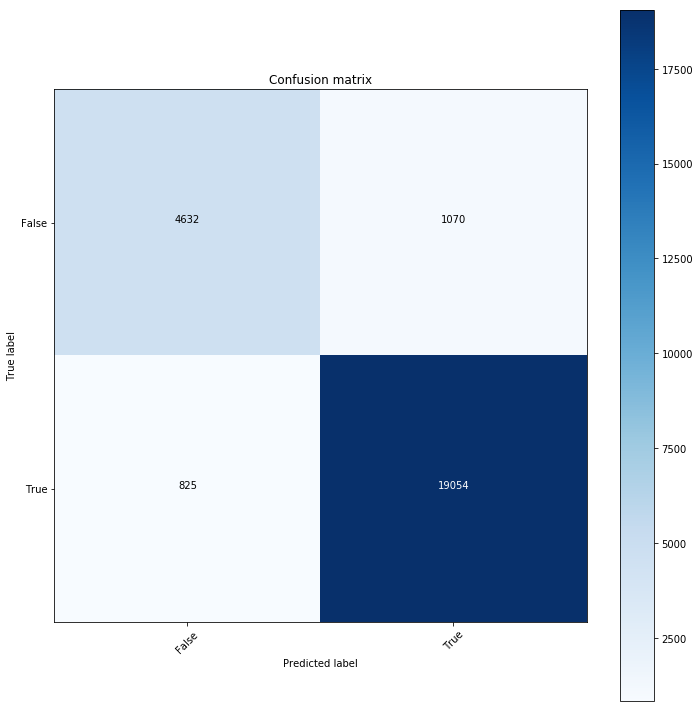

In [31]:
plt.figure(figsize=(10,10))
cnf_matrix = metrics.confusion_matrix(Y_val, Y_pred)
np.set_printoptions(precision=2)
plots.plot_confusion_matrix(cnf_matrix,classes)

### layer size optimization

In [37]:
F=252
hidden1=512
results=[]

for E in [100,200,300]:
        # Build the Estimator
        model=text_conv_net(W,V,E,F,hidden1)
        model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])
        model.fit(X_train,Y_train,epochs=5,validation_data=(X_val,Y_val),batch_size=100)
        Y_pred=(model.predict(X_train)>0.5).ravel()
        acc_train=np.mean(Y_pred==Y_train)
        Y_pred=(model.predict(X_val)>0.5).ravel()
        acc_val=np.mean(Y_pred==Y_val)
        print(E,F,hidden1,acc_train,acc_val)
        results.append((E,F,hidden1,acc_train,acc_val))
        

Train on 486027 samples, validate on 25581 samples
Epoch 1/5
486027/486027 [==============================] - 160s 330us/step - loss: 0.2574 - acc: 0.8947 - val_loss: 0.2062 - val_acc: 0.9167
Epoch 2/5
486027/486027 [==============================] - 155s 318us/step - loss: 0.1766 - acc: 0.9317 - val_loss: 0.1977 - val_acc: 0.9238
Epoch 3/5
486027/486027 [==============================] - 156s 320us/step - loss: 0.1343 - acc: 0.9490 - val_loss: 0.1928 - val_acc: 0.9262
Epoch 4/5
486027/486027 [==============================] - 157s 324us/step - loss: 0.1044 - acc: 0.9605 - val_loss: 0.2152 - val_acc: 0.9270
Epoch 5/5
486027/486027 [==============================] - 158s 325us/step - loss: 0.0840 - acc: 0.9684 - val_loss: 0.2217 - val_acc: 0.9277
100 252 512 0.9869040197355291 0.9276807005199171
Train on 486027 samples, validate on 25581 samples
Epoch 1/5
486027/486027 [==============================] - 204s 420us/step - loss: 0.2560 - acc: 0.8953 - val_loss: 0.2032 - val_acc: 0.9178
Ep

In [38]:
data=pd.DataFrame(results,columns=["E","F","layer1","train","valuation"])
data.head()

,E,F,layer1,train,valuation
0,100,252,512,0.986904,0.927681
1,200,252,512,0.987818,0.928541
2,300,252,512,0.988375,0.928932


The best model achieves 93% accuracy using a 300 dimensional embedding, 256 (3,4,5) n-grams and and a 512 hidden layer.

We could probably do better by increasing model size, but we need to stop somewhere.

### Test of best model

In [39]:
X=np.concatenate([X_train,X_val])
Y=np.concatenate([Y_train,Y_val])
print(X.shape,Y.shape)

(511608, 125) (511608,)


In [40]:
best_E=300
F=256
best_hidden_layer=512

In [43]:
# Build the Estimator
model=text_conv_net(W,V,best_E,F,best_hidden_layer)
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.001), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [44]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           (None, 125)          0                                            
__________________________________________________________________________________________________
embedding_47 (Embedding)        (None, 125, 300)     15000600    input_48[0][0]                   
__________________________________________________________________________________________________
conv1d_141 (Conv1D)             (None, 125, 256)     153856      embedding_47[0][0]               
__________________________________________________________________________________________________
conv1d_142 (Conv1D)             (None, 125, 256)     230656      embedding_47[0][0]               
__________________________________________________________________________________________________
conv1d_143

This model is a **very large** so fitting takes a while

In [46]:
model.fit(X,Y,epochs=5,validation_data=(X_test,Y_test),batch_size=100)

Train on 511608 samples, validate on 56846 samples
Epoch 1/5
511608/511608 [==============================] - 263s 515us/step - loss: 0.2508 - acc: 0.8977 - val_loss: 0.1983 - val_acc: 0.9219
Epoch 2/5
511608/511608 [==============================] - 264s 517us/step - loss: 0.1729 - acc: 0.9333 - val_loss: 0.1828 - val_acc: 0.9283
Epoch 3/5
511608/511608 [==============================] - 264s 516us/step - loss: 0.1286 - acc: 0.9513 - val_loss: 0.1905 - val_acc: 0.9305
Epoch 4/5
511608/511608 [==============================] - 265s 517us/step - loss: 0.0982 - acc: 0.9632 - val_loss: 0.2048 - val_acc: 0.9323
Epoch 5/5
511608/511608 [==============================] - 264s 516us/step - loss: 0.0790 - acc: 0.9706 - val_loss: 0.2062 - val_acc: 0.9326


In [47]:
Y_pred=(model.predict(X_test)>0.5).ravel()
np.mean(Y_pred==Y_test)

0.9325898040319459

So we achieve 93.2% accuracy on the test set